In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import dataclasses
import math
import os
import xarray as xr
import salem
import geopandas as gpd
import pandas as pd
import quilt
import skimage
import pygmt
import pyproj
from tqdm import tqdm
from tools import *

In [297]:
c_point = (1068000,1273000)
resolution = 1000
x_range = 5
y_range = 7
pad = 14
stride = 84
step = 112
EI_1_pad_region = rasterio.coords.BoundingBox(left=c_point[0]-y_range*stride*resolution/2-pad*resolution,
                                        bottom=c_point[1]-x_range*stride*resolution/2-pad*resolution,
                                        right=c_point[0]+y_range*stride*resolution/2+pad*resolution,
                                        top=c_point[1]+x_range*stride*resolution/2+pad*resolution)

EI_1_region = rasterio.coords.BoundingBox(left=c_point[0]-y_range*stride*resolution/2,
                                        bottom=c_point[1]-x_range*stride*resolution/2,
                                        right=c_point[0]+y_range*stride*resolution/2,
                                        top=c_point[1]+x_range*stride*resolution/2)


In [61]:
save_file = ""

In [62]:
EI_1_region

BoundingBox(left=774000.0, bottom=1063000.0, right=1362000.0, top=1483000.0)

In [275]:
def read_one_xyz(filename):
    xyz = []
    y=0
    with open(filename, 'r') as f:
        content = f.read()
        contact = content.split('\n')
        contact = contact[20:-1]
        for line in tqdm(contact):

            atom = line.split(',')

            xyzitem = {'LON': atom[2],'LAT': atom[3],'ELEVATION': atom[7]}
            xyz.append(xyzitem)
    return xyz



In [286]:
xyz_data1 = pd.DataFrame(read_one_xyz(f"/home/user/files/hyl/original_data/AWI_2016_OIR_AIR_BM3.csv")).astype('float32')

100%|██████████| 563666/563666 [00:00<00:00, 647080.58it/s]


In [286]:
xyz_data1 = pd.DataFrame(read_one_xyz(f"/home/user/files/hyl/original_data/AWI_2016_OIR_AIR_BM3.csv")).astype('float32')

100%|██████████| 563666/563666 [00:00<00:00, 647080.58it/s]


In [197]:
/home/user/files/hyl/original_data/AWI_2016_OIR_AIR_BM3.csv

NameError: name 'home' is not defined

In [ ]:
xyz_data  = pd.merge(xyz_data1, xyz_data, how='outer')

In [287]:
xyz_data

,LON,LAT,ELEVATION,z
0,33.157001,-79.253799,3416.800049,3416.800049
1,33.158699,-79.253899,3414.260010,3414.260010
2,33.160301,-79.254097,3411.649902,3411.649902
3,33.161999,-79.254204,3410.899902,3410.899902
4,33.163601,-79.254303,3409.229980,3409.229980
...,...,...,...,...
610902,40.061199,-69.023102,365.500000,365.500000
610903,40.054501,-69.022003,370.399994,370.399994
610904,40.051498,-69.021202,394.200012,394.200012
610905,40.048599,-69.020401,394.399994,394.399994


In [278]:
xyz_data.loc[:, 'z'] = xyz_data['ELEVATION']

In [279]:
xyz = xyz_data[['LON','LAT',  'ELEVATION']]
xyz.rename(columns={'LON':'x', 'LAT':'y'}, inplace=True)
# xyz = xyz[['x', 'y', 'z']]

/home/user/anaconda3/envs/DEEPMAP/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [280]:
xyz

,x,y,ELEVATION
0,33.157001,-79.253799,3416.800049
1,33.158699,-79.253899,3414.260010
2,33.160301,-79.254097,3411.649902
3,33.161999,-79.254204,3410.899902
4,33.163601,-79.254303,3409.229980
...,...,...,...
610902,40.061199,-69.023102,365.500000
610903,40.054501,-69.022003,370.399994
610904,40.051498,-69.021202,394.200012
610905,40.048599,-69.020401,394.399994


In [281]:
xyz_array = xyz
p1 = pyproj.CRS.from_string(in_crs_string="EPSG:4326")
p2 = pyproj.CRS.from_string(in_crs_string="EPSG:3031")
reprj_func = pyproj.Transformer.from_crs(crs_from=p1, crs_to=p2, always_xy=True)
x2, y2 = reprj_func.transform(xx=np.array(xyz_array["x"]), yy=np.array(xyz_array["y"]))
xyz_array["x"] = pd.Series(x2)
xyz_array["y"] = pd.Series(y2)

/home/user/anaconda3/envs/DEEPMAP/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/user/anaconda3/envs/DEEPMAP/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [282]:
xyz_array

,x,y,ELEVATION
0,6.404049e+05,9.802460e+05,3416.800049
1,6.404280e+05,9.802180e+05,3414.260010
2,6.404435e+05,9.801819e+05,3411.649902
3,6.404662e+05,9.801531e+05,3410.899902
4,6.404876e+05,9.801261e+05,3409.229980
...,...,...,...
610902,1.482846e+06,1.763358e+06,365.500000
610903,1.482719e+06,1.763626e+06,370.399994
610904,1.482684e+06,1.763773e+06,394.200012
610905,1.482653e+06,1.763916e+06,394.399994


In [283]:
xyz_array.to_csv(f'{save_file}/BM2TOXYZ.csv')

In [284]:
# 读取PDFRAME
df = xyz_array

# 找到x和y列的最小和最大值
x_min = df['x'].min()
x_max = df['x'].max()
y_min = df['y'].min()
y_max = df['y'].max()
# 计算中心点坐标
x_center = int((x_min + x_max) / 2)   # 转换为千米
y_center = int((y_min + y_max) / 2)   # 转换为千米

# 计算长宽
width = np.ceil(((x_max - x_min) / 1000)/28)   # 转换为千米
height =np.ceil (((y_max - y_min) / 1000 )/28) # 转换为千米

print('中心点坐标：', x_center , y_center )
print('长：', width, '千米')
print('宽：', height, '千米')
print('x的范围：', x_min, ' 到 ', x_max)
print('y的范围：', y_min, ' 到 ', y_max)

中心点坐标： 835802 1304468
长： 59.0 千米
宽： 40.0 千米
x的范围： 11346.116200700413  到  1660258.884872987
y的范围： 745683.53375  到  1863252.6439710062


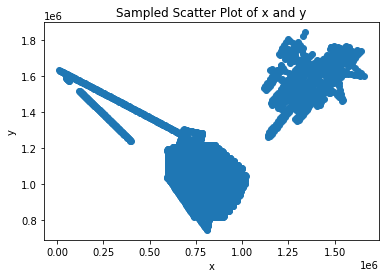

In [285]:

# 抽样
sampled_df = df.iloc[::100, :]

# 绘制抽样后的散点图
plt.scatter(sampled_df['x'], sampled_df['y'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sampled Scatter Plot of x and y')
plt.show()

In [237]:
c_point = (1204787,1370234)
resolution = 250
x_range = 5*4
y_range = 7*4
pad = 14
stride = 84
step = 112
EI_1_pad_region = rasterio.coords.BoundingBox(left=c_point[0]-y_range*stride*resolution/2-pad*resolution,
                                        bottom=c_point[1]-x_range*stride*resolution/2-pad*resolution,
                                        right=c_point[0]+y_range*stride*resolution/2+pad*resolution,
                                        top=c_point[1]+x_range*stride*resolution/2+pad*resolution)

EI_1_region = rasterio.coords.BoundingBox(left=c_point[0]-y_range*stride*resolution/2,
                                        bottom=c_point[1]-x_range*stride*resolution/2,
                                        right=c_point[0]+y_range*stride*resolution/2,
                                        top=c_point[1]+x_range*stride*resolution/2)


In [207]:
def read_one_xyz(filename):
    xyz = []
    with open(filename, 'r') as f:
        content = f.read()
        contact = content.split('\n')
        contact = contact[11:-1]
        for line in tqdm(contact):
            # print(line[0])
            if line[0]=='343':
            # 'F' and line[0] == ' ' and line[0] == 'P' and line[0] == 'C' and line[0] == 'E' and line[0] == 'L' and line[0] == 'S' and line[0] == '*' and line[0] == 'O' and line[0] == '/' and line[0] == 'C' and line[0] == 'A' and line[0] == 'K' and line[0] == 'R'
        
                continue
            else:
                atom = line.split(',')
                xyzitem = {'a': atom[0],'x': atom[1],'y': atom[2],'z': atom[3]}
                xyz.append(xyzitem)
    return xyz
# xyz = read_one_xyz(data_list[0])


In [208]:
To_data = pd.DataFrame(read_one_xyz(f"{save_file}/BM23TOXYZ.csv"))

100%|██████████| 610897/610897 [00:00<00:00, 695849.52it/s]


In [209]:
To_data = To_data[['x', 'y', 'z']].astype(np.float32)

In [ ]:
sparse_data = To_data

In [303]:
region = EI_1_region
selected_sparse_data = sparse_data
selected_sparse_data = selected_sparse_data[selected_sparse_data['x']>=region.left]
selected_sparse_data = selected_sparse_data[selected_sparse_data['x']<=region.right]
selected_sparse_data = selected_sparse_data[selected_sparse_data['y']>=region.bottom]
selected_sparse_data = selected_sparse_data[selected_sparse_data['y']<=region.top]
selected_sparse_data = selected_sparse_data.reset_index(drop=True)

In [305]:
selected_sparse_data

,x,y,z
0,1204747.125,1454096.875,2103.100098
1,1204625.250,1453908.375,2113.500000
2,1204461.750,1453669.750,2118.399902
3,1204417.125,1453605.500,2116.399902
4,1204253.000,1453366.250,2106.699951
...,...,...,...
4171,1290841.250,1453403.500,2343.899902
4172,1290841.250,1453403.500,2347.000000
4173,1290973.500,1453583.250,2350.000000
4174,1291283.125,1454008.375,2346.600098


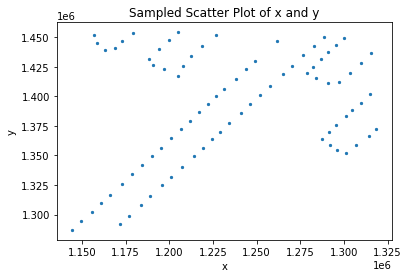

In [306]:
df = selected_sparse_data# 抽样
sampled_df = df.iloc[::50, :]

# 绘制抽样后的散点图
plt.scatter(sampled_df['x'], sampled_df['y'], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sampled Scatter Plot of x and y')
plt.show()

In [307]:
from multiprocessing import Pool

x_max = int((region.right - region.left) / resolution)
y_max = int((region.top - region.bottom) / resolution)
data_array = np.zeros((1, y_max, x_max))

def calculate_mean(args):
    x, y = args
    data_piece = selected_sparse_data[(selected_sparse_data['x'] >= region.left + resolution * x)
                                      & (selected_sparse_data['x'] <= region.left + resolution * (x + 1))
                                      & (selected_sparse_data['y'] >= region.bottom + resolution * y)
                                      & (selected_sparse_data['y'] <= region.bottom + resolution * (y + 1))]
    return x, y, data_piece['z'].mean()

def update_data_array(result):
    x, y, mean = result
    data_array[0][y_max - 1 - y][x] = mean

with Pool() as pool:
    results = []
    with tqdm(total=x_max * y_max) as pbar:
        for x in range(x_max):
            for y in range(y_max):
                args = (x, y)
                results.append(pool.apply_async(calculate_mean, args=(args,), callback=update_data_array))
                pbar.update()

    for result in tqdm(results):
        result.get()

print(data_array)


100%|██████████| 620928/620928 [00:56<00:00, 11055.93it/s]


[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


In [242]:
data_array[0,0,0]

nan

In [243]:
np.shape(data_array)
data_array[ data_array == data_array[0,0,0] ] = -9999

In [308]:
data_array = np.nan_to_num(data_array, nan=-9999)
data_array
np.mean(data_array[data_array!=-9999])

2136.544710186326

In [309]:
np.save(f"{save_file}/sparse_grid.npy", np.nan_to_num(data_array, nan=-9999))

In [340]:
sparse_grid = np.load(f"{save_file}/sparse_grid.npy")

## 制作REMA-THICKNESS

In [315]:
REMA = selective_tile(filepath=f"/home/user/files/yzj/misc/REMA_200m_dem_filled.tif", resolution = resolution, window_bounds=[EI_1_region])

Tiling: /home/user/files/yzj/misc/REMA_200m_dem_filled.tif ... 

/home/user/anaconda3/envs/DEEPMAP/lib/python3.7/site-packages/xarray/core/indexing.py:1207: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


done!


In [317]:
REMA.shape

(1, 1, 672, 924)

In [318]:
sparse_grid.shape

(1, 672, 924)

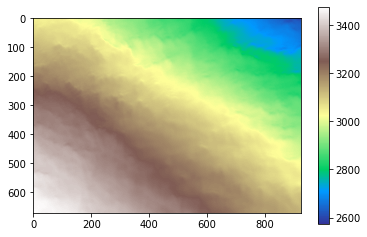

In [319]:
plt.imshow(REMA[0,0,...], cmap='terrain')
plt.colorbar()

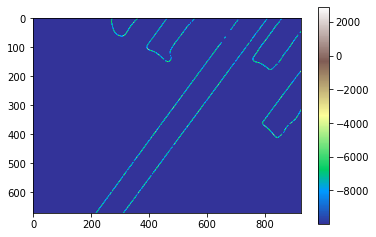

In [320]:
# sparse_grid[0,...] = array_x_y
nopadsparse = []
nopadsparse = sparse_grid[0,...]
plt.imshow(nopadsparse, cmap='terrain')
plt.colorbar()

In [321]:
remaline = (nopadsparse>-9998)*REMA[0,0,...]
elevation = (remaline-nopadsparse)
elevation[nopadsparse==-9999]=-9999
elevation = elevation[np.newaxis,:,:]

In [325]:
np.save(f"{save_file}/sparse_gridt.npy",elevation)

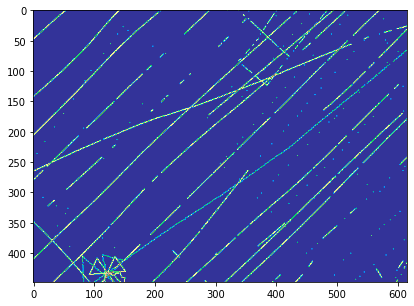

In [342]:
# sparse_grid = np.load(f"{save_file}/sparse_grid.npy")
fig = plt.figure(figsize=(10,5))
plt.imshow(sparse_grid[0,...], cmap='terrain')
# plt.colorbar()

In [83]:
sparse_grid.shape

(1, 448, 616)

In [84]:
save_array_to_grid(
    window_bound=EI_1_pad_region,
    array=sparse_grid.astype(dtype=np.int16),
    outfilepath=f"{save_file}/sparse_grid",
    dtype=np.int16,
    tiled=True,
    compression=rasterio.enums.Compression.lzw.value,  # Lempel-Ziv-Welch, lossless
)

In [85]:
sparse_grid.shape

(1, 448, 616)

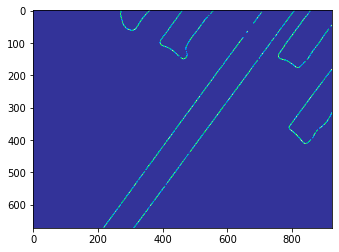

In [339]:
plt.imshow((sparse_grid[0]>-9999), cmap='terrain')
plt.colorbar()

In [87]:
sparse_grid_image = sparse_grid[0]

In [88]:
step

112

In [89]:
# cut grid image into pieces
sparse_grid_image[sparse_grid_image==0]=-9999

array = np.expand_dims(np.expand_dims(sparse_grid_image, 0), 0)
for x in tqdm(range(0, array.shape[2]-step+stride, stride)):
    for y in range(0, array.shape[3]-step+stride, stride):
        if x is 0 and y is 0:
            crop_array = array[:, :, x:x+step, y:y+step]
            # print(crop_array.shape)
        else: 
            # print(y+step-y)
            crop_array = np.concatenate((crop_array, array[:, :, x:x+step, y:y+step]))
print(crop_array.shape)

100%|██████████| 5/5 [00:00<00:00, 314.22it/s]

(35, 1, 112, 112)


In [90]:
np.save(f"{save_file}/crop_grid.npy", crop_array)

(420, 588)


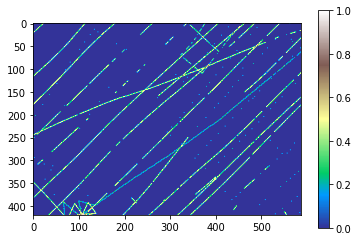

In [91]:
array = crop_array[:, :, pad:-pad, pad:-pad]
for x in range(x_range):
    for y in range(y_range):
        if y == 0:
            array_y = array[x*y_range + y][0]
        else:
            array_y = np.concatenate((array_y, array[x*y_range + y][0]), 1)
    if x == 0:
        array_x_y = array_y
    else:
        array_x_y = np.concatenate((array_x_y, array_y), 0)
print(array_x_y.shape)
plt.imshow((array_x_y>-9999), cmap='terrain')
plt.colorbar()

In [92]:
array = crop_array
data_rate = []
for i in tqdm(range(array.shape[0])):
    rate = ((array[i]>-9998).sum()) / array[i].size
    data_rate.append(rate)

100%|██████████| 35/35 [00:00<00:00, 15509.84it/s]


In [93]:
data_rate

[0.01865433673469388,
 0.023278061224489797,
 0.011240433673469387,
 0.017697704081632654,
 0.04400510204081633,
 0.03930165816326531,
 0.026227678571428572,
 0.025669642857142856,
 0.021045918367346938,
 0.021922831632653062,
 0.039381377551020405,
 0.039540816326530615,
 0.022002551020408163,
 0.025191326530612245,
 0.03316326530612245,
 0.025589923469387755,
 0.024792729591836735,
 0.022321428571428572,
 0.01610331632653061,
 0.020966198979591837,
 0.03164859693877551,
 0.023278061224489797,
 0.02040816326530612,
 0.016183035714285716,
 0.025111607142857144,
 0.02702487244897959,
 0.03300382653061224,
 0.008051658163265306,
 0.040736607142857144,
 0.050302933673469385,
 0.024473852040816327,
 0.028300382653061226,
 0.03714923469387755,
 0.012675382653061224,
 0.0052614795918367345]

In [94]:
rate_x = 0.005
loc = []
for i in tqdm(range(len(data_rate))):
    if data_rate[i] > rate_x:
        loc.append(i)
len(loc)

100%|██████████| 35/35 [00:00<00:00, 175809.15it/s]


35

In [95]:

countrate = []
for i in tqdm(range(len(data_rate))):
    if data_rate[i] > rate_x:
        countrate.append(data_rate[i])
print(len(countrate))
np.mean(countrate)

100%|██████████| 35/35 [00:00<00:00, 321931.23it/s]

35


0.025763028425655976

In [96]:
np.save(f"{save_file}/loc.npy", loc)

(420, 588)


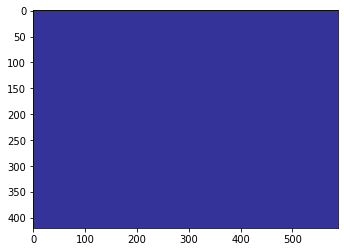

In [97]:
array = crop_array[:, :, pad:-pad, pad:-pad]

zeros_array = np.zeros((stride, stride))
ones_array = np.ones((stride, stride))

for x in range(x_range):
    for y in range(y_range):
        if x*y_range + y in loc:
            array = ones_array
        else:
            array = zeros_array
        if y == 0:
            array_y = array
        else:
            array_y = np.concatenate((array_y, array), 1)
    if x == 0:
        array_x_y = array_y
    else:
        array_x_y = np.concatenate((array_x_y, array_y), 0)
print(array_x_y.shape)
plt.imshow(array_x_y, cmap='terrain')

In [98]:
j = 0
for i in tqdm(loc):
    if j==0:
        sel_array = np.expand_dims(crop_array[i], 0)
        # print(sel_array.shape)
    else:
        sel_array = np.concatenate((sel_array, np.expand_dims(crop_array[i], 0)), 0)
    j = j + 1
# print(sel_array.shape)

100%|██████████| 35/35 [00:00<00:00, 2260.28it/s]


In [99]:
rate = []
for i in tqdm(range(len(loc))):
    a = (sel_array[i]!=-9999).sum()/(sel_array[i]!=-9998).sum()
    rate.append(a)

100%|██████████| 35/35 [00:00<00:00, 10685.74it/s]


In [100]:
sel_array = np.nan_to_num(sel_array, 0)
sel_array.shape

(35, 1, 112, 112)

In [101]:
np.save(f"{save_file}/sel_crop_{len(loc)}_rate_{rate_x}.npy", sel_array)

## 制作maskandnpy


In [102]:

projname = "QMLside"
maskname = f"{save_file}/npymask{projname}/"
gtname = f"{save_file}/Antgroundtruth{projname}/"
img = np.load(f"{save_file}/sel_crop_{len(loc)}_rate_{rate_x}.npy")    #使用numpy载入npy
img.shape

(35, 1, 112, 112)

In [103]:
os.mkdir(maskname)
os.mkdir(gtname)

In [104]:
num = img[0,0,0,0]
num

-9999.0

In [105]:
for i in range(img.shape[0]):
    im = img[i,0,:,:]
    for j in range(112):
        for k in range(112):
            if im[j,k] == num:
                im[j,k] = 255
            else:
                im[j,k] = 0
    np.save(maskname + str(i) + ".npy", im)

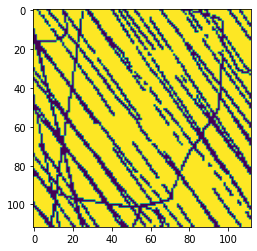

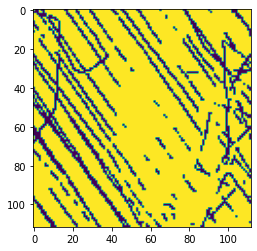

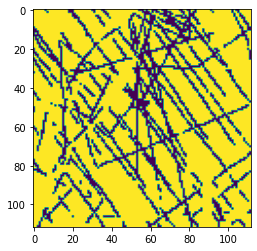

In [144]:
for i in range(3):
    img = np.load(maskname+f'{i}.npy') 
    plt.imshow(img) 
    plt.show()

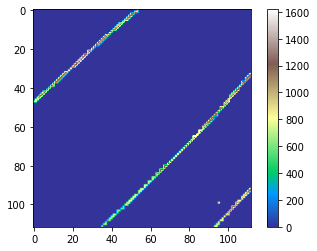

1618.140380859375


In [106]:
img = np.load(f"{save_file}/sel_crop_{len(loc)}_rate_{rate_x}.npy") 
for i in range(img.shape[0]):
    im = img[i,0,:,:]
    for j in range(112):
        for k in range(112):
            if im[j,k] == num:
                im[j,k] = 0
    np.save(gtname + str(i) + ".npy", im)
img = np.load(gtname+'0.npy')   
plt.imshow(img) 
plt.imshow(img,cmap = 'terrain') 
plt.colorbar()   
plt.show()  
print(np.max(img))

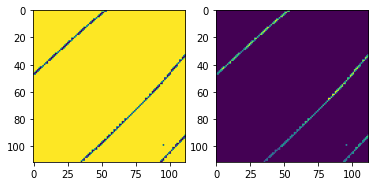

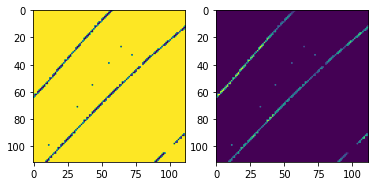

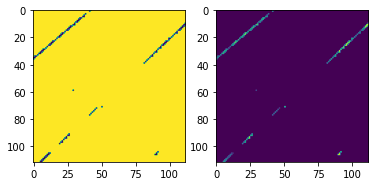

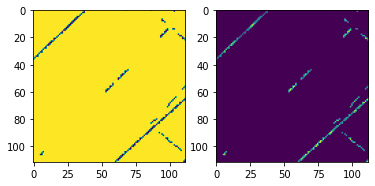

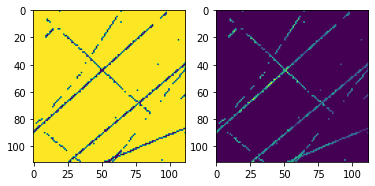

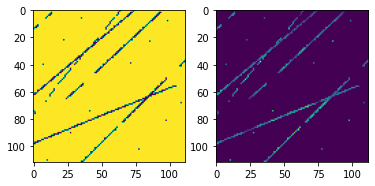

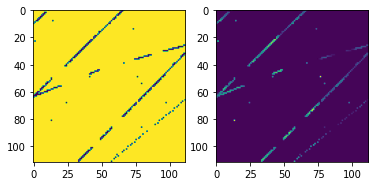

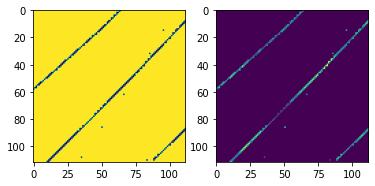

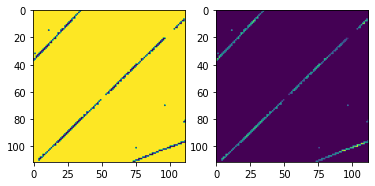

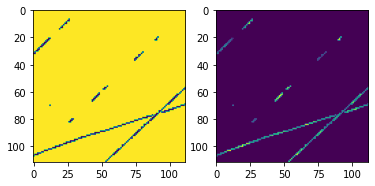

In [107]:
for i in range(10):
    img1 = np.load(maskname+f'{i}.npy') 
    img2 = np.load(gtname+f'{i}.npy') 
    plt.subplot(121)
    plt.imshow(img1) 
    plt.subplot(122)
    plt.imshow(img2)  
    plt.show()

## 合成

In [133]:
FName = f"{save_file}/testQMLside/"
FName

'/home/user/files/hyl//chaofen2/QMLside//testQMLside/'

In [134]:
projname = "QMLside"

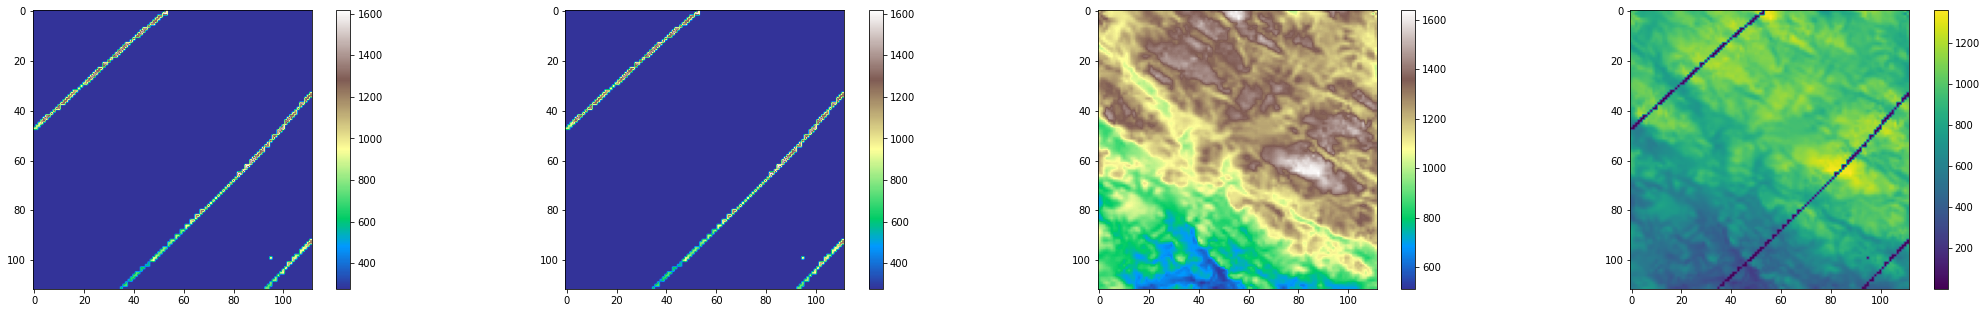

844.4901633800955


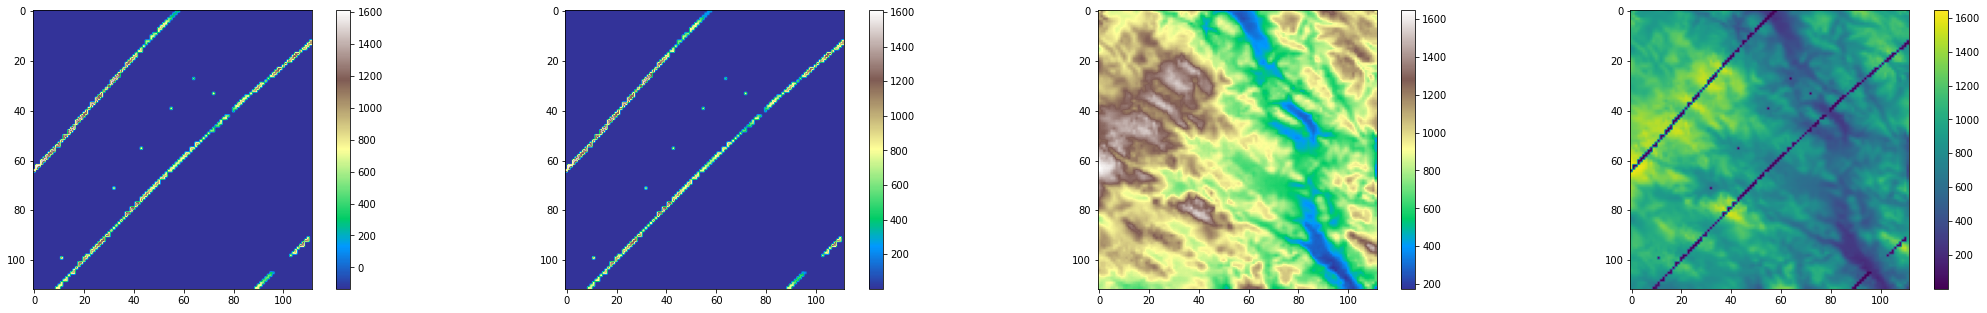

873.8377310589617


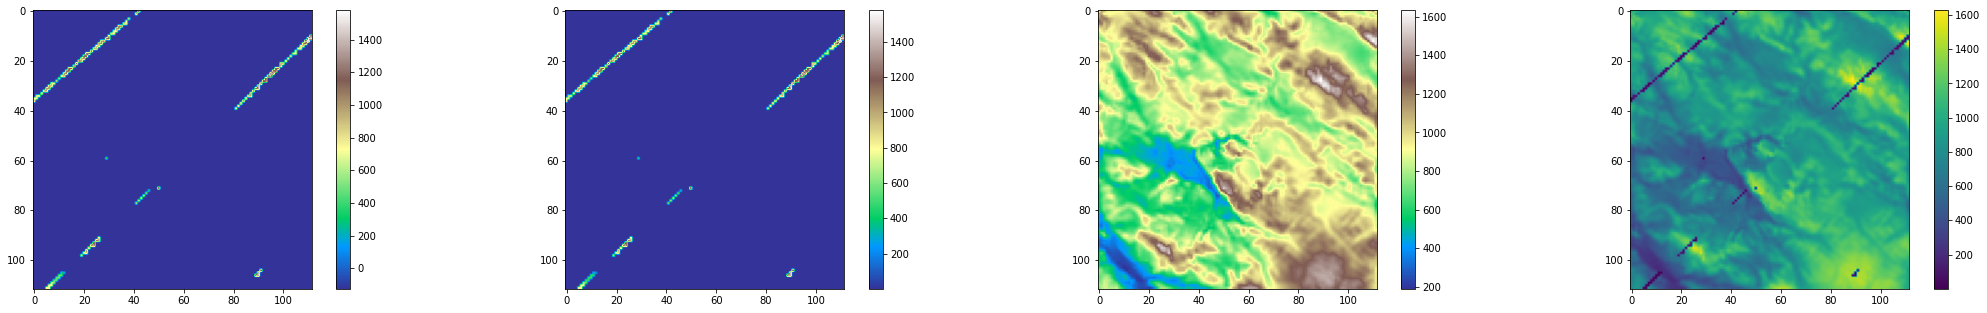

872.2179703421557
863.5152882604043


In [124]:

# FName = '/home/user/files/hyl/antnet/result/RNRF/test/'
error = []
for i in range(3):
    # ./testantr/test_20
    img1 = np.load(FName+ str(i+1) + '__in.npy')
    img2 = np.load(FName+ str(i+1) + '__gt.npy')
    img3 = np.load(FName+ str(i+1) + '__pre1.npy')
    # img4 = np.load('./ite_'+ num + '_'+str((i+1)*10)+'_pred2.npy')
    fig, axs = plt.subplots(1,4, figsize=(30, 5))
    plt.subplot(141)
    plt.imshow(img1[:,:],cmap = 'terrain')
    plt.colorbar()
    # plt.show()  
    plt.subplot(142)
    plt.imshow(img2[:,:],cmap = 'terrain')
    plt.colorbar()
    # plt.show()  
    plt.subplot(143)
    plt.imshow(img3[:,:],cmap = 'terrain')
    plt.colorbar()
    fig.tight_layout(pad=3.0)
    
    # img5 = (img2 - img3)/np.max(img2)
    # plt.subplot(144)
    # plt.imshow(img5[:,:])
    # plt.colorbar()
    # fig.tight_layout(pad=3.0)
    res = abs(img2-img3)
    plt.subplot(144)
    plt.imshow(res[:,:])
    plt.colorbar()
    plt.show()  
    error.append(res.mean())
    print(res.mean())
print(np.mean(error))

In [125]:
images = []
for i in range(round(len(os.listdir(FName))/4)):
    filename = FName + str(i+1) + '__pre1.npy'
    image = np.load(filename)
    images.append(image)
result = np.stack(images, axis=0)
images = np.array(images)
result.shape
np.save(f"{save_file}/ant{projname}",result)

In [126]:
result.shape

(35, 112, 112)

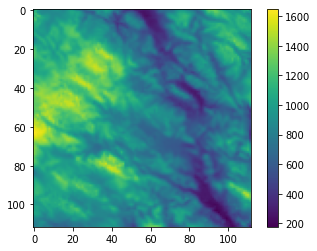

In [127]:
plt.imshow(result[1,...])
plt.colorbar()
plt.show()

拼

In [128]:
sel_array = np.load(f'{save_file}/ant{projname}.npy')
# sel_array = np.load('sel_crop_490_rate_0.02.npy')
loc = np.load(f'{save_file}/loc.npy')
loc = loc.tolist()
sel_array = sel_array[:, np.newaxis, :, :]

In [129]:
# sel_array = np.load(f'/home/user/files/hyl/misf-main/result/antAWI1000m.npy')

In [130]:
crop_arraynorm = np.ones ((sel_array.shape[0],1,112,112))
for i in range(sel_array.shape[0]):
    if np.min(sel_array[i,0,...])<-3000:
        crop_arraynorm[i,0,...] = np.zeros((112,112))
    else:
        crop_arraynorm[i,0,...] = sel_array[i,0,...]

In [131]:
# data_array = sel_array[:,:, 14:-14, 14:-14]
data_array = crop_arraynorm[:,:, 14:-14, 14:-14]
none_array = np.zeros((84, 84))
data_array.shape

(35, 1, 84, 84)

(420, 588)


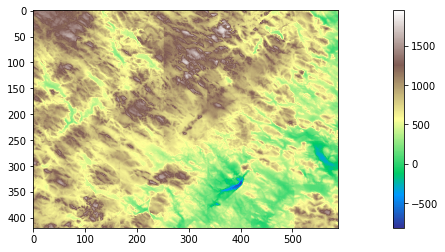

In [132]:
for x in range(x_range):
    for y in range(y_range):
        i = x*y_range + y
        if i in loc:
            array = data_array[loc.index(i)][0]
        else:
            array = none_array
        if y == 0:
            array_y = array            
        else:
            array_y = np.concatenate((array_y, array), 1)
    if x == 0:
        array_x_y = array_y
    else:
        array_x_y = np.concatenate((array_x_y, array_y), 0)
print(array_x_y.shape)
fig = plt.figure(figsize=(20,4))
plt.imshow(array_x_y, cmap='terrain')
plt.colorbar()
plt.show()


In [135]:
inpainted = array_x_y

In [136]:
np.save(f"inpaintedAnt_{projname}",array_x_y)

In [137]:
name = f"inpaintedAnt_{projname}"
save_array_to_grid(
    window_bound=EI_1_region,
    array=np.expand_dims(array_x_y, 0).astype(dtype=np.int16),
    outfilepath=f"{save_file}/{name}",
    dtype=np.int16,
    tiled=True,
    compression=rasterio.enums.Compression.lzw.value,  # Lempel-Ziv-Welch, lossless
)